In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

plt.style.use("seaborn-v0_8-whitegrid")

df_hourly = pd.read_csv("wroclaw_ml_hourly.csv", parse_dates=["time"], index_col="time")
df_hourly = df_hourly.sort_index()
df_hourly = df_hourly.loc["2016-01-01":"2018-12-31"]


In [2]:
from baseline_daily_predictions import prep_data, evaluate_model

In [3]:
# Data Preparation
df_daily = prep_data()

# Split (Test = Last 365 Days)
last_timestamp = df_daily.index.max()

cutoff_date = last_timestamp - pd.Timedelta(days=365)

train = df_daily[df_daily.index <= cutoff_date]
test = df_daily[df_daily.index > cutoff_date].copy()

print(f"Train set: {train.index.min().date()} to {train.index.max().date()}")
print(f"Test set: {test.index.min().date()} to {test.index.max().date()}")

Train set: 2015-01-01 to 2025-01-17
Test set: 2025-01-18 to 2026-01-17


In [4]:
def add_yearly_cyclical_features(df):
    day_of_year = df.index.dayofyear
    df = df.copy()
    df["doy_sin"] = np.sin(2 * np.pi * day_of_year / 365.25)
    df["doy_cos"] = np.cos(2 * np.pi * day_of_year / 365.25)
    return df


train = add_yearly_cyclical_features(train)
test = add_yearly_cyclical_features(test)

exog_cols = ["doy_sin", "doy_cos"]


In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


def train_and_predict_sarimax(
    train_df,
    test_df,
    target_col,
    exog_cols,
    model_name,
    ord,
    sord,
):
    y_train = train_df[target_col]
    y_test = test_df[target_col]

    exog_train = train_df[exog_cols]
    exog_test = test_df[exog_cols]

    model = SARIMAX(
        y_train,
        exog=exog_train,
        order=ord,
        seasonal_order=sord,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )

    result = model.fit(disp=False, maxiter=50)

    forecast = result.get_forecast(
        steps=len(test_df),
        exog=exog_test,
    )

    y_pred = forecast.predicted_mean

    print(f"\n=== {model_name} ({target_col}) ===")
    print(result.summary().tables[1])

    return y_pred, result


In [11]:
# ===== DAY =====
pred_day_sarimax, res_day = train_and_predict_sarimax(
    train,
    test,
    target_col="target_temp_day",
    exog_cols=exog_cols,
    model_name="SARIMAX Day",
    ord=(7, 0, 3),
    sord=(0,0,0,0),
)

# ===== NIGHT =====
pred_night_sarimax, res_night = train_and_predict_sarimax(
    train,
    test,
    target_col="target_temp_night",
    exog_cols=exog_cols,
    model_name="SARIMAX Night",
    ord=(7, 0, 3),
    sord=(0,0,0,0),
)


=== SARIMAX Day (target_temp_day) ===
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
doy_sin       -2.7783      0.237    -11.745      0.000      -3.242      -2.315
doy_cos      -10.3833      0.239    -43.490      0.000     -10.851      -9.915
ar.L1          0.5607      0.024     22.899      0.000       0.513       0.609
ar.L2          0.3048      0.033      9.354      0.000       0.241       0.369
ar.L3          0.7654      0.033     23.349      0.000       0.701       0.830
ar.L4         -0.6738      0.026    -25.470      0.000      -0.726      -0.622
ar.L5          0.1162      0.021      5.525      0.000       0.075       0.157
ar.L6         -0.0679      0.020     -3.468      0.001      -0.106      -0.030
ar.L7         -0.0054      0.017     -0.318      0.750      -0.039       0.028
ma.L1          0.2233      0.022     10.072      0.000       0.180       0.267
ma.L2        

/home/werka/venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



--- SARIMAX (Yearly Seasonality) ---
[Day  ] RMSE: 4.13, MAE: 3.35, R2: 0.77
[Night] RMSE: 3.75, MAE: 2.98, R2: 0.73


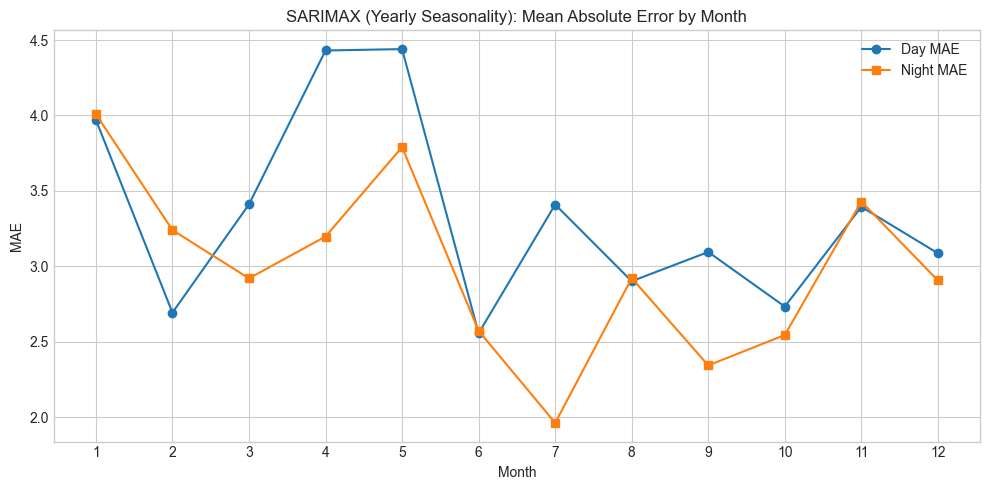

In [12]:
evaluate_model(
    test["target_temp_day"],
    pred_day_sarimax,
    test["target_temp_night"],
    pred_night_sarimax,
    "SARIMAX (Yearly Seasonality)",
    test
)


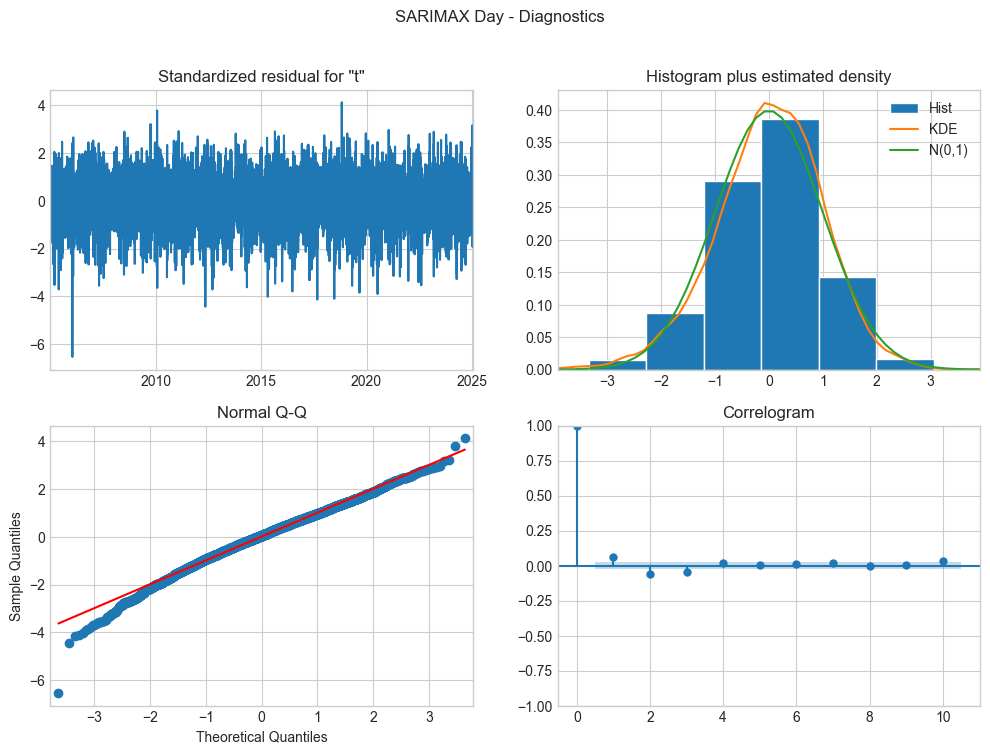

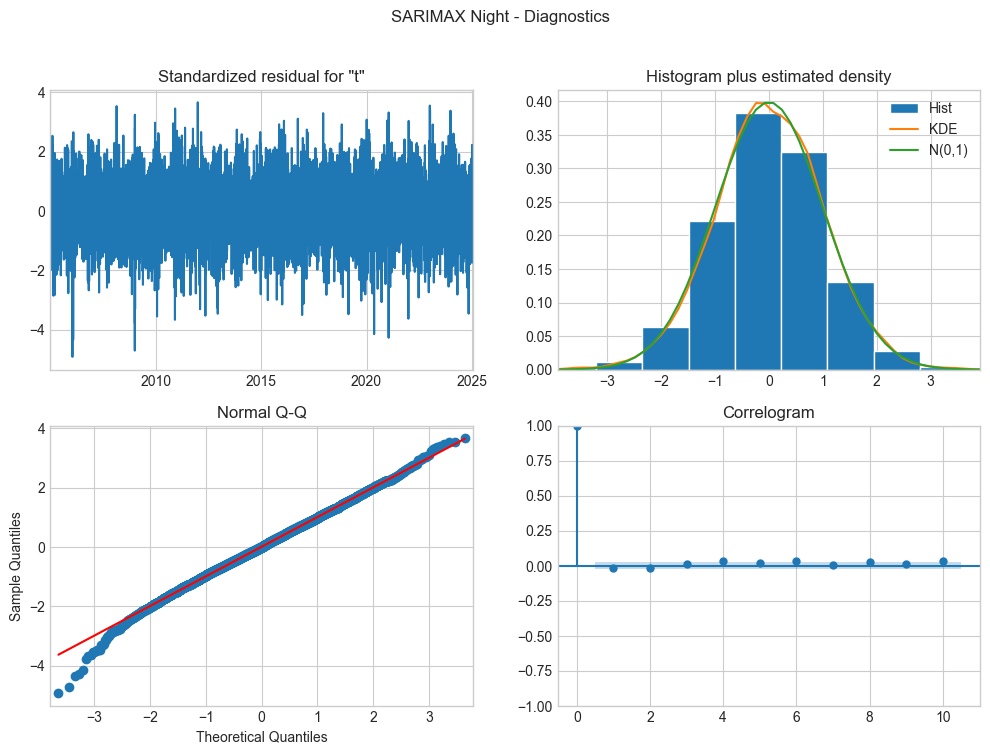

In [ ]:
res_day.plot_diagnostics(figsize=(12, 8))
plt.suptitle("SARIMAX Day - Diagnostics")
plt.show()

res_night.plot_diagnostics(figsize=(12, 8))
plt.suptitle("SARIMAX Night - Diagnostics")
plt.show()
